### General Overview
-When doing research on syntopic weather systems, it is important to see their virtical structure by taking crossections with respesct to height levels. The purpose of this notebook is to explore a method to scan an area by vertical cross sections and to either draw a plot or returning a video (Essentially generated by [Matplotlib.FuncAnimation()](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html)).

-Packages involved: xarray, matplotlib, cartopy, numpy, and metpy.\
-Other than one interactive function, the notebook has all parameters for function set up to run. However, there were tons of work done for standardization, so feel free to change the variable you want to look at after you walk through this notebook. \
-You don't really need to type any code, this is just for let you get familar with the funtions in this package!

In [2]:
import xarray as xr, matplotlib.pyplot as plt, numpy as np
import metpy.calc as mpcalc
import matplotlib.colors as mplc
from metpy.units import units
import Scanner

The data we use here is from [ERA5 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=form). Theoretically, the data can generate crossections from any dataset retrieved from ERA5 dataset as long as the variables in the dataset includes temperature and geopotential height. 

-At first, we need to read the data by xarray function.\
-Because the default names in the dataset is too long, we should change some variables/coordinate's name at first.\
 (You don't need to do this step at all if you are comfortable with the default!)\
-Potential temperature and vorticity will be used later. Because we don't have them in the raw dataset, we need to calculate them by metpy function ([mpcalc.potential_temperature()](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.potential_temperature.html)).

In [3]:
ds=xr.open_dataset('./testdata/feb1512z.grib', engine='cfgrib')
ds=ds.metpy.quantify()
ds=ds.rename({"isobaricInhPa":"pressure","latitude":"lat", "longitude":"lon"})
 #You need to process some data at first before puting it into function
ds['thta']=mpcalc.potential_temperature(ds.pressure, ds.t) #We don't have thta at beginning 
ds['vo'] = mpcalc.vorticity(ds.u,ds.v)
ds['z']=ds.z/9.8 #To calculate geopotential height, the value need to be devided by $g$
#Take a look with the processed dataset!
ds

/home/wen/anaconda3/envs/plot/lib/python3.10/site-packages/metpy/xarray.py:355: UserWarning: More than one time coordinate present for variable "u".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


<xarray.Dataset>
Dimensions:     (pressure: 27, lat: 121, lon: 281)
Coordinates:
    number      int64 0
    time        datetime64[ns] 2023-02-15T12:00:00
    step        timedelta64[ns] 00:00:00
  * pressure    (pressure) float64 1e+03 975.0 950.0 925.0 ... 150.0 125.0 100.0
  * lat         (lat) float64 50.0 49.75 49.5 49.25 ... 20.75 20.5 20.25 20.0
  * lon         (lon) float64 -140.0 -139.8 -139.5 -139.2 ... -70.5 -70.25 -70.0
    valid_time  datetime64[ns] 2023-02-15T12:00:00
Data variables:
    z           (pressure, lat, lon) float32 <Quantity([[[   91.4202      90....
    pv          (pressure, lat, lon) float32 <Quantity([[[-1.2834789e-08 -1.6...
    t           (pressure, lat, lon) float32 <Quantity([[[278.68237 278.63745...
    u           (pressure, lat, lon) float32 <Quantity([[[  9.163666    9.189...
    v           (pressure, lat, lon) float32 <Quantity([[[-2.067749   -2.3909...
    w           (pressure, lat, lon) float32 <Quantity([[[-2.88496017e-02 -3....
    thta        (pressure, lat, lon) float64 <Quantity([[[278.68237305 278.63...
    vo          (pressure, lat, lon) float64 <Quantity([[[-2.91261154e-05 -2....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-01-12T00:55 GRIB to CDM+CF via cfgrib-0.9.1...

There are many occasions that we only need to look at a small area do out research and draw crossections, so the following ```selection()``` function is defined. \
-The function acts as a specified version of [.sel()](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.sel.html?highlight=.sel()#xarray.Dataset.sel) function in xarray

What you can specify in this function:\
-Only the veriables you want for later use.\
-Area of the interest\
-Pressure level of interest (Only one level at a time! Essential for the initial map, but please don't specify when doing crossection!)\
-The index value of time you want (Only one at a time!)

In [4]:
def selection(dataset,  vrbs, extent=None, plevel=None, tidx=None):
    r'''
    Parameters
    ----------
    dataset: 'xarray.Dataset' 
        The dataset imported before.
    vrbs: 'list'
        Variables want to keep in the new xarray dataset. Should be a list of names consistent with the name of variable in the xarray.Dataset (Or what resutns by doing list(dataset.keys())).
        Example:['t', 'z', 'w']
    extent=None: 'list'
        Should be 2 pairs of lat, lon values in a least, use the dataset's span in lat&lon if not specified.
        (Example: [-130,-60,20, 52] (This is a CONUS view!))
    plevel:'int'
        The pressure level want to keep in the new dataset.
        (One level only)
    tidx:'int'
        Time index in the old dataset that you want to keep in the new dataset.
        (One time only)
    
    Returns
    -------
    'xarray.Dataset'
        The filtered dataset. 
    '''

Since we haven't have our points for cross sections defined, we need to prepare a dataset on some pressure level to identify our area of interest. Hence, we need to slice out some data in one pressure level to generates maps in later functions.\
<b>-Note: Certainly, we can't make cross section for a dataset that only in one pressure level, so we will call ```selection()``` at a later time!</b> 

In [5]:
ds1=Scanner.selection(ds, ['z', 'thta', 'vo'], extent=[-130,-60,20, 52], plevel=500)
ds1

AttributeError: module 'Scanner' has no attribute 'selection'

The next step is to confirm the coordinate that we wnat to do the scanning.

However, before introducing the function, I need to introduce the parameters for setting the plotting parameters at first. \
-All the specifing parameters for plotting in any plot-related functions below should be typed in a dictionary at first.

The following is the default dictionary in the package!:

In [ ]:
###Example!

pv_cmap = list(reversed(['#f80000', '#fa2c0c', '#fc4017', '#fe5121', '#ff5f2c', '#ff6d36', '#ff7a40', 
               '#ff864a', '#ff9153', '#ff9c5d', '#ffa666', '#ffb070', '#ffba79', '#ffc383', 
               '#d5b17c', '#b29e73', '#968965', '#867152', '#845336', '#9b0000']))
w_cmap = list(reversed(['#00007f', '#2f278e', '#49469c', '#5f65aa', '#7485b8', '#8aa5c5', '#a4c6d1', '#fbfbdc', '#fbfbdc', '#ffdea4', '#ffcd88', '#ffbb6c', '#ffa952', '#ff9538', '#ff7f1f', '#ff6600']))
pv_cmap = mplc.ListedColormap(pv_cmap)
w_cmap = mplc.ListedColormap(w_cmap)

default={'contour':{
                 'thta':{'level': np.arange(250, 450, 3),
                         'color':'red',
                         'linewidths':1,
                         'title':"Potential temperature (K)"},
                    'z':{'level': np.arange(0, 10000, 60),
                         'color':'black',
                         'linewidths':1, 
                         'title': "Geopotential height (m)"},
                    't':{'level': np.arange(0, 400, 3),
                         'color':'black',
                         'linewidths':1, 
                         'title': "Temperature (K)"}},
             'fill':{
                   'vo':{'level': np.arange(5e-5,40e-5,5e-5),
                         'cmap':plt.cm.YlOrRd,
                         'title': "Relative vorticity(1/s)"},
                    'pv':{'level': np.arange(-1e-6,9.1e-6,0.5e-6),
                         'cmap':pv_cmap, #Defined in the .py file. You are welcomed to check!
                         'title': "Potential vorticity(PVU)"},
                    'w':{'level': np.arange(-4, 4.1, 0.5),
                         'cmap':w_cmap, #Defined in the .py file. You are welcomed to check!
                         'title': "Omega(Pa/s)"}}}
  

As you can see, there are in total of 3 layers in this dictionary. A picture for explaining dictionary structure is mentioned in the README file, 
but I am also putting one here for quick reference.

<img src='plotfile.png' width='360' height='240'/>

Please feel free to change the plotfile dictionary file of you want to plot some other parameters, but it has to be in the following format:\
If it is a contour, attach the following to ```'contour'```:
```python 
   'variable name':#Your variable name in the dataset
             {
             'level': #Your contour interval, should be a numpy array
             'color': #Your contour color, should be a string with full name of color (It will be written on the title!)
             'linewidth': #How wide you want your line is. should be in int type
             'title': #Your variable's official name with a unit (Named as title because it is mainly used in title
             }
```
If it is a filled contour, attach the following to ```'fill'```:
```python 
   'variable name': #Your variable name in the dataset
            { 
             'level': #Your contour interval, should be a numpy array
             'cmap': #Your colormap, should be the name of the colorbar after plt.cm
             'title': #Your variable's official name with a unit (Named as title because it is mainly used in title
             }
```
Here is [a link for colormaps in matplotlib](https://matplotlib.org/stable/gallery/color/colormap_reference.html)

It doesn't need to be a perfect match for the name of variable to do the plotting--The plotting fuction actually only runs when the <b>same variable name</b> is in both the dataset and the plotfile dictionary here.

<font color='red'><b>Old function, it is now renamed as ```estimation_3pts()```</b></font>
<p>Now it's the time to explain the function ```estimation(dataset, pos1=[None, None], pos2=[None, None], pos3=[None, None], plotfile=plotfile)```. <br>
This function is an interactive function for generating coordinate for the scanner. What you must put is a dataset with lat/lon or latitude/longitude as x&y axis and a plotfile for plotting parameters. Initially, no matter have you decided your coordinates yet or not for the scanner, a base map is drawn for you to see what happens on the lat&lon surface. Lat and lon are given by ticks for adding convenience. </p>

At the beginning, if you have your coordinates decided you can just put each pair of them in the location you want(It can also run if you have't decided one of the locations yet)

Note, each of the pos# slot corresponds to following:<br>
-<font color='red'>pos1(Show later as red dot)</font>: Initial point of first cross section\
-<font color='orange'>pos2(Show later as orange dot)</font>: Final point of first cross section\
-<font color='teal'>pos3(Show later as teal dot)</font>: First point of last cross section 


If you want to fix your coordinate, type something other than <b>y</b> or <b>Y</b> (This is case insensitive!!!).\
Your new input should be numbers typed like following "lat1, lon1, lat2, lon2, lat3, lon3" (compatible for both float and int, mainly requiring each number separated by commas, no worries on the spaces)

However, if you just want to change only one parameter, you can always type <b>None or something else for the rest of part</b>.\
If you want to leave by whatever reason, just type <b>y</b> or <b>Y</b>.

<b>A test lat/lon pairs is given here:</b> 32.0, -125.0, 47.0, -120.0, 25.0, -102.0

<b>Remember you need to put the dataset and plotfile before you run the function! (For here as I have everything set up already so you can ignore)\
    And, you can assign an variable in front of the function to store the output! (I also let the function print the coords out so not necessary).</b>

<b>New feature! The output will now be a tuple. If you want to see the location of the cross-session in the scanner, you can use the second item in the output tuple in the ```prec= ``` in ```scanner()```</b>

In [7]:
#Also check if the output is assigned!
output[0]

(32.0, -125.0, 47.0, -120.0, 25.0, -102.0)

At this time, since we were choosing a certain pressure level, we need to run ```selection()``` again to get a dataset with info on <b>all pressure levels</b>.\
-You can also assign other variables to your new dataset for scanning (For example, here chooses <b>temperature</b> and <b>vertial wind</b> this time instead of geopotential height and vorticity).

In [8]:
#Do another selection (Please don't select a pressure level this time!)
ds2=Scanner.selection(ds, ['t', 'thta', 'w'], extent=[-130,-60,20, 52])
ds2

<xarray.Dataset>
Dimensions:     (pressure: 27, lat: 121, lon: 241)
Coordinates:
    number      int64 0
    time        datetime64[ns] 2023-02-15T12:00:00
    step        timedelta64[ns] 00:00:00
  * pressure    (pressure) float64 1e+03 975.0 950.0 925.0 ... 150.0 125.0 100.0
  * lat         (lat) float64 50.0 49.75 49.5 49.25 ... 20.75 20.5 20.25 20.0
  * lon         (lon) float64 -130.0 -129.8 -129.5 -129.2 ... -70.5 -70.25 -70.0
    valid_time  datetime64[ns] 2023-02-15T12:00:00
Data variables:
    t           (pressure, lat, lon) float32 <Quantity([[[278.04175 277.49097...
    thta        (pressure, lat, lon) float64 <Quantity([[[278.04174805 277.49...
    w           (pressure, lat, lon) float32 <Quantity([[[-8.62226486e-02 -2....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-03-26T22:24 GRIB to CDM+CF via cfgrib-0.9.1...

Now, here is the scanner function ```scanner(slice_idx, dataset, coords_list, steps='default', plotfile=plotfile, plot=True)```, depending of the input, the scanner function has output in 3 types. \
-Video\
-Image\
-Frame for video/gif (Should just be used by function itself to make video)

Among the parameters for the function, for generating output, you must have:\
-dataset     :Your dataset to do scanning\
-coords_list :Your list of coordinates for scanning, generated from coords_generator()\
-plotfile    :As you can see when you check the function, although you must have it, you are free to use the default plotfile existing in this notebook (Just remember to name your dictionary as plotfile.

To have <b>video</b> as output, you need to do the following besides setting up above essential parameters:\
-Set slice_idx = None: (Since you are generating a video instead of an image of a specific slice of cross section.)\
-Set     plot = False: (Setting the mod for video)\
Example: ```scanner(None, ds2, coords_list, plotfile=plotfile, plot=False)```

To have <b>image</b> as output, you need to do the following besides setting up above essential parameters:\
-Set slice_idx as an integer: (indicating the index of cross section slice to be obtained)\
-Set plot = True: (This is also a default, so you can skip this part)\
Example: ```scanner(0, ds2, coords_list, plotfile=plotfile)```

Regarding the steps, that is about how many crossections images (or the number of steps) you want to get for the scanning.\
The default number of step is the magnitude in degrees plus 1 between the start and end point.
- If you want more steps, put integers in `steps`, like ```steps=10```.

In order to see the cross section, put the second item in the output tuple to ```prec=```.

Note: The core function for finding intermidiate points is realized by [metpy.interpolate.geodesic()](https://unidata.github.io/MetPy/latest/api/generated/metpy.interpolate.geodesic.html#geodesic)

Here is an example for generating crossection at the start point.

<AxesSubplot: title={'left': 'From: 32.0 N, -125.0 W, to: 47.0 N, -120.0 W', 'right': 'Valid time:2023-02-15 12:00Z'}, ylabel='Pressure (hPa) '>

<Figure size 640x480 with 0 Axes>

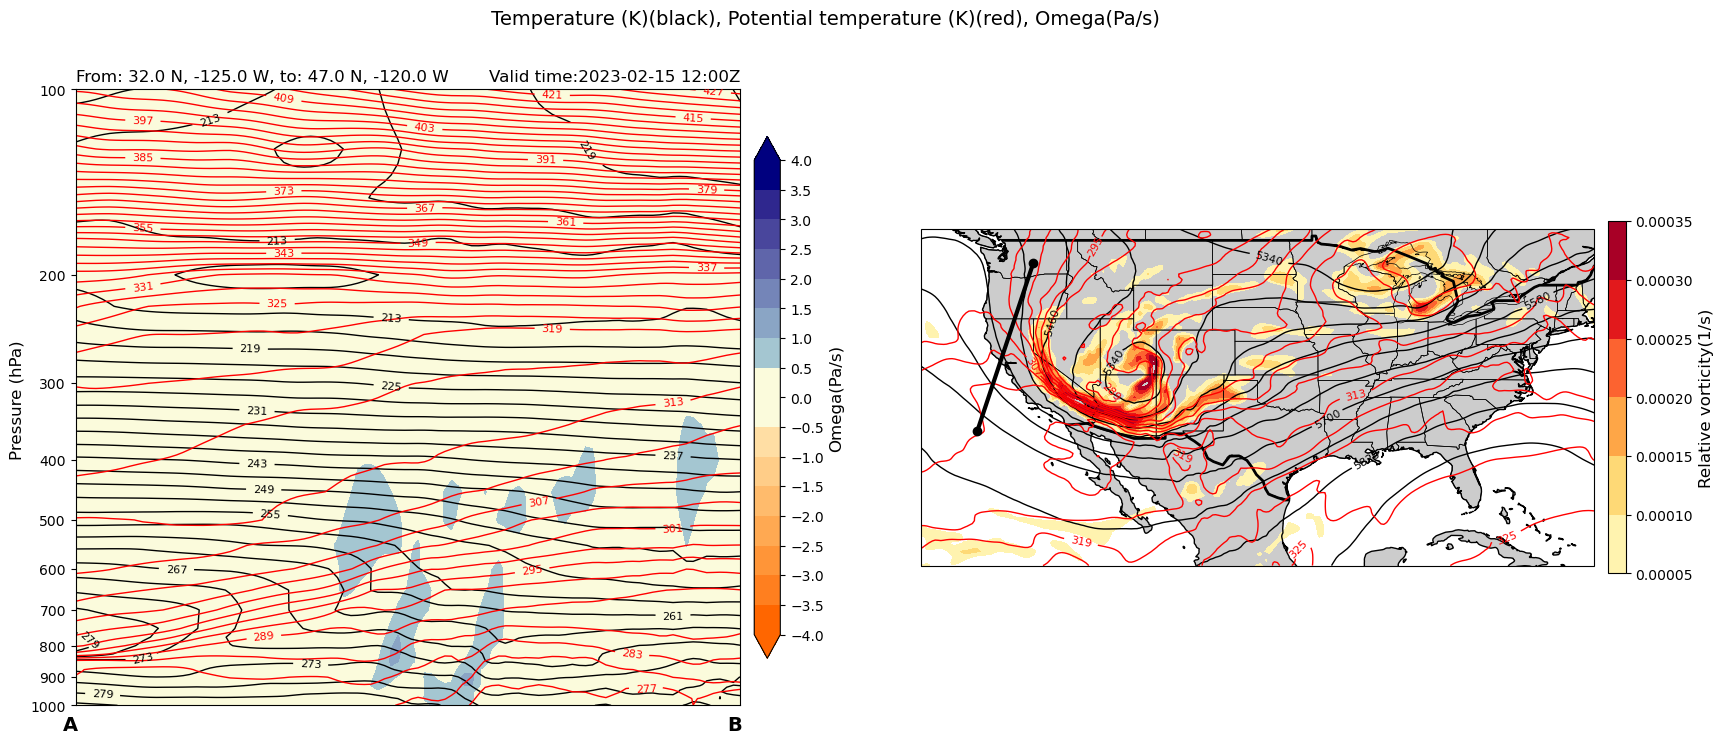

In [9]:
coordsinfo, map = output
Scanner.scanner(0, ds2, coordsinfo, plotfile='default', plot=True, prec=map)
#As it is doing indexing, you can change the index to -1 for getting the last cross section.

In [10]:
#Here is an example for video (Takes a bit time ~30s on my own laptop!)
Scanner.scanner(None, ds2, coordsinfo, plotfile='default', plot=False, prec=map)

<Figure size 640x480 with 0 Axes>

As one of the final goal of this notebook is to make video by the scanner function. We can change some parameters for the scanner function to run the embedded [matplotlib.animation.FuncAnimation()](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html) here.

### Last words
This notebook's objective is not only making cross section from example, but also creating standardized function for doing such work by any data from the [ERA5 database](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=form). However, the original vision of this project is even further--creating standerized functions that can take any atmospheric or oceanic .grib format data to do cross section scanning. I still want this to be my half way goal--as all of these functions are planned to be in a module that can do atmospheric and oceanolographic scanning in different perspectives (Virtical Crossection, Horizontal Elevation, and Time lapse of a given layer and location), and eventually use for generating plots for my future research and my personal website.